<a href="https://colab.research.google.com/github/janosepah/ML_Project/blob/master/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Predicting Electricity Supply and Demand
Team Members (alphabetical order):
-	Samarah Azimpoor
-	Safoura Janosepah


# Power Data Source - IESO

## Market Demand
### Market Demand Definitions and Graphs
The graph below plots values for both Total Market Demand and Ontario Demand.

- **Total Market Demand** represents the total energy that was supplied from the IESO-Administered Market.

The IESO calculates Total Market Demand by summing all output from generators registered in the Market plus all scheduled imports to the province. It is also equal to the sum of all load supplied from the Market plus exports from the province, plus all line losses incurred on the IESO-controlled grid.

- **Ontario Demand** represents the total energy that was supplied from the IESO-Administered Market for the purpose of supplying load within Ontario.

It is also equal to the sum of all loads within Ontario which is supplied from the Market, plus all line losses incurred on the IESO-controlled grid.


##**Table of Content**

1.   Importing Liblaries
2.   Loading the Data
3.   Data Pre-Processing
4.   Feature Engineering
5.   Data Visualisation
6.   Designing Models
 
 6.1.   XGBoost
       * Train & Test Split
       * Creating XGBoost model
       * Prediction
       * EvaluationList item
 
 6.2.  RNN
       * Train & Test Split
       * Creating RNN model
       * Prediction
       * EvaluationList item
 
 6.3.   LSTM
       * Train & Test Split
       * Creating LSTM model
       * Prediction
       * EvaluationList item

7.    Evaluating Final Models



##1. **Importing Liblaries**

In [123]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
import calendar


In [124]:
# Set default plot styles
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (16, 6)
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.labelsize'] = 14

##2. **Loading The Data**

In [125]:
# Load Data 
Data_Path = 'https://raw.githubusercontent.com/janosepah/ML_Project/master/Data/'

# Demand
Demand_2017 = pd.read_csv(Data_Path + 'PUB_Demand_2017.csv', parse_dates=['Date'])
Demand_2017.head()
#Demand_2017.shape

Demand_2018 = pd.read_csv(Data_Path + 'PUB_Demand_2018.csv', parse_dates=['Date'])
Demand_2018.head()
#Demand_2018.shape

Demand_2019 = pd.read_csv(Data_Path + 'PUB_Demand_2019.csv', parse_dates=['Date'])
Demand_2019.head()
#Demand_2019.shape

# Supply
Supply_2017 = pd.read_csv(Data_Path + '2017_Hourly_Output.csv', parse_dates=['Date'])
Supply_2017.head()
#Supply_2017.shape

Supply_2018 = pd.read_csv(Data_Path + '2018_Hourly_Output.csv', parse_dates=['Date'])
Supply_2018.head()
#Supply_2018.shape

Supply_2019 = pd.read_csv(Data_Path + '2019_Hourly_Output.csv', parse_dates=['Date'])
Supply_2019.head()
#Supply_2019.shape

# Industry
Industrial_2019 =pd.read_csv(Data_Path + 'Industrial_Load_2019.csv', parse_dates=['DeliveryDate'])
Industrial_2019.head()

Industrial_2018 =pd.read_csv(Data_Path + 'Industrial_Load_2018.csv', parse_dates=['DeliveryDate'])
Industrial_2018.head()

Industrial_2017 =pd.read_csv(Data_Path + 'Industrial_Load_2017.csv', parse_dates=['DeliveryDate'])
Industrial_2017.head()

# DemandZonal
DemandZonal_2017 =pd.read_csv(Data_Path + 'PUB_DemandZonal_2017.csv', parse_dates=['Date'])
DemandZonal_2017.head()

DemandZonal_2018 =pd.read_csv(Data_Path + 'PUB_DemandZonal_2018.csv', parse_dates=['Date'])
DemandZonal_2018.head()

DemandZonal_2019 =pd.read_csv(Data_Path + 'PUB_DemandZonal_2019.csv', parse_dates=['Date'])
DemandZonal_2019.head()

# FuelMonthly
FuelMonthly_2017 =pd.read_csv(Data_Path + 'PUB_GenOutputbyFuelMonthly_2017.csv')
FuelMonthly_2017.head()

FuelMonthly_2018 =pd.read_csv(Data_Path + 'PUB_GenOutputbyFuelMonthly_2018.csv')
FuelMonthly_2018.head()

FuelMonthly_2019 =pd.read_csv(Data_Path + 'PUB_GenOutputbyFuelMonthly_2019.csv')
FuelMonthly_2019.head()


,DeliveryYear,Month,Fuel,EnergyGW
0,2019,January,NUCLEAR,8057.99
1,2019,January,GAS,941.07
2,2019,January,HYDRO,3422.35
3,2019,January,WIND,1435.37
4,2019,January,SOLAR,24.86


## 3. Data Pre-Processing

Merging Data

In [154]:
# Demand
AllDemand= Demand_2017.append(Demand_2018)
AllDemand= AllDemand.append(Demand_2019)
#AllDemand.shape

# Supply
AllSupply= Supply_2017.append(Supply_2018)
AllSupply= AllSupply.append(Supply_2019)
#AllSupply.shape


# Industry
AllIndustry= Industrial_2017.append(Industrial_2018)
AllIndustry= AllIndustry.append(Industrial_2019)
#AllIndustry

# DemandZonal
AllDemandZonal= DemandZonal_2017.append(DemandZonal_2018)
AllDemandZonal= AllDemandZonal.append(DemandZonal_2019)
#AllDemandZonal

# FuelMonthly
AllFuel= FuelMonthly_2017.append(FuelMonthly_2018)
AllFuel= AllFuel.append(FuelMonthly_2019)


In [155]:
AllFuel.head()

,DeliveryYear,Month,Fuel,EnergyGW
0,2017,January,NUCLEAR,8387.85
1,2017,January,GAS,554.10
2,2017,January,HYDRO,3231.18
3,2017,January,WIND,1045.20
4,2017,January,SOLAR,17.66


In [156]:
AllDemandZonal.head()

,Date,Hour,Ontario Demand,Northwest,Northeast,Ottawa,East,Toronto,Essa,Bruce,Southwest,Niagara,West,Zone Total,Diff
0,2017-01-01,1,13522,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"2,268"
1,2017-01-01,2,13117,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"2,673"
2,2017-01-01,3,12816,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"2,974"
3,2017-01-01,4,12605,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"3,186"
4,2017-01-01,5,12563,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"3,227"


In [157]:
AllIndustry.head()

,DeliveryDate,Hour,QtyIronSteel,QtyMetalOre,QtyMotorVehicle,QtyPetroCoal,QtyPulpPaper,QtyOtherIndstr,QtyManufactr,QtyElecPower,QtyLdc,QtyDirectConnect
0,2017-01-01,1,284,580,48,140,187,101,293,255,"11,313","12,960"
1,2017-01-01,2,325,591,48,140,192,100,296,254,"10,916","12,625"
2,2017-01-01,3,330,569,48,140,193,101,296,251,"10,561","12,251"
3,2017-01-01,4,356,584,48,140,196,101,298,250,"10,314","12,050"
4,2017-01-01,5,321,590,48,140,195,102,298,251,"10,234","11,941"


In [158]:
AllSupply.head()

,Date,Hour,NUCLEAR,GAS,HYDRO,WIND,SOLAR,BIOFUEL,Total Output
0,2017-01-01,1,11592,234,2455,2433,0,1,16715
1,2017-01-01,2,11591,235,2523,1994,0,1,16344
2,2017-01-01,3,11596,234,2464,1647,0,1,15942
3,2017-01-01,4,11610,236,2494,1386,0,1,15727
4,2017-01-01,5,11611,235,2476,1330,0,1,15653


In [159]:
AllDemand.head()

,Date,Hour,Market Demand,Ontario Demand
0,2017-01-01,1,17172,13522
1,2017-01-01,2,16757,13117
2,2017-01-01,3,16370,12816
3,2017-01-01,4,16075,12605
4,2017-01-01,5,16050,12563


##4. Feature Engineering



Adding some featurs to the dataset

In [134]:
# Add Day & Month
# Demand
AllDemand['Date'] = pd.to_datetime(AllDemand['Date']) 
AllDemand['Day'] = AllDemand['Date'].dt.day_name() 
AllDemand['Month'] = pd.DatetimeIndex(AllDemand['Date']).month 
AllDemand['Month'] = AllDemand['Month'].apply(lambda x: calendar.month_abbr[x])

# Supply
AllSupply['Date'] = pd.to_datetime(AllSupply['Date']) 
AllSupply['Day'] = AllSupply['Date'].dt.day_name()
AllSupply['Month'] = pd.DatetimeIndex(AllSupply['Date']).month 
AllSupply['Month'] = AllSupply['Month'].apply(lambda x: calendar.month_abbr[x])

#Industry
AllIndustry['DeliveryDate'] = pd.to_datetime(AllIndustry['DeliveryDate']) 
AllIndustry['Day'] = AllIndustry['DeliveryDate'].dt.day_name()
AllIndustry['Month'] = pd.DatetimeIndex(AllIndustry['DeliveryDate']).month 
AllIndustry['Month'] = AllIndustry['Month'].apply(lambda x: calendar.month_abbr[x])

# DemandZonal
AllDemandZonal['Date'] = pd.to_datetime(AllDemandZonal['Date']) 
AllDemandZonal['Day'] = AllDemandZonal['Date'].dt.day_name()
AllDemandZonal['Month'] = pd.DatetimeIndex(AllDemandZonal['Date']).month 
AllDemandZonal['Month'] = AllDemandZonal['Month'].apply(lambda x: calendar.month_abbr[x])


In [137]:
#Add Index
AllDemand.set_index(['Date'], inplace=True)

##5. Data Visualisation

**Exploratory Analysis**
Since the frequency currently is in the hourly level, this will make it difficult to visualise. So we will resample it and aggregate it to a daily/weekly and monthly level.

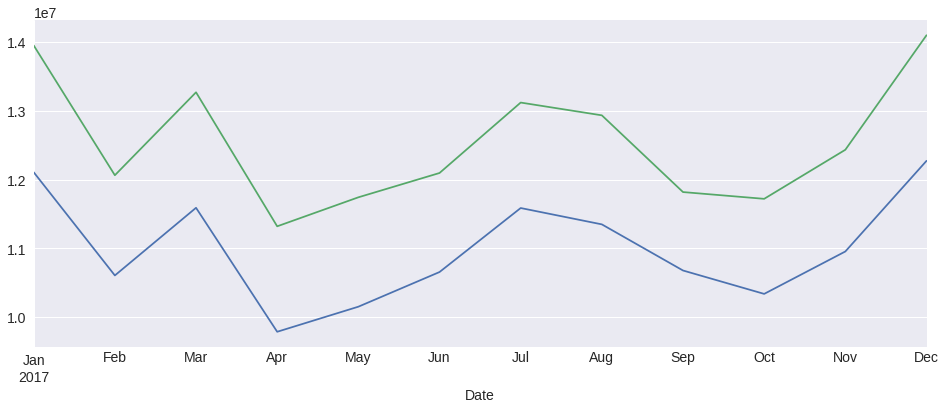

In [150]:
Monthly_data = Demand.resample(rule='M').sum()
Monthly_data = weekly_data.asfreq('M')
Monthly_data['Ontario Demand'].plot();
Monthly_data['Market Demand'].plot();

In [131]:
#Now there's a tail end where it's not a full day, so it's dropping off.

#For our purposes, we will just delete that part day.

daily_data = daily_data.drop([daily_data.index.min(), daily_data.index.max()])

**Data Visualisation**
We can see the pattern in data- electricity usage seem to be very seasonal and repetitive. This makes sense, it migh be due to weather patterns,  holidays, weekends etc.
Furthermore, you can see the trend of the data seems to be trailing upwards in the last few years.

In [132]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.dates import DateFormatter

In [133]:
weekly_data = Ontario_Demand.resample(rule='W').sum()
decomposition = seasonal_decompose(weekly_data, model='additive') # Aggregate to weekly level

fig = decomposition.plot()
plt.show()

NameError: ignored

## 6. Designing Models

###6.1. XGBoost



####Train & Test Split


####Creating XGBoost model

####Prediction

####EvaluationList item

###6.2. RNN

####Train & Test Split

####Creating RNN model

####Prediction

####Evaluation

###6.3. LSTM

####Train & Test Split

####Creating LSTM model

####Prediction

####Evaluation

##7. Evaluating Final Models